In [22]:
# dataset @ https://finance.yahoo.com/quote/MSFT/history/

# If you want the exact same dataset as the YouTube video,
# use this link: https://drive.google.com/file/d/1WLm1AEYgU28Nk4lY4zNkGPSctdImbhJI/view?usp=sharing

In [23]:
import pandas as pd

df_jpm = pd.read_csv('data/jpm_bars_2024-03-06.csv')

df_jpm.tail()

,symbol,timestamp,open,high,low,close,volume,trade_count,vwap
2051,JPM,2024-02-28 00:00:00-05:00,183.43,185.20,182.96,184.38,6131608.0,90914.0,184.413387
2052,JPM,2024-02-29 00:00:00-05:00,185.66,186.43,183.85,186.06,9642256.0,100032.0,185.571020
2053,JPM,2024-03-01 00:00:00-05:00,185.70,186.44,185.10,185.29,6311997.0,93783.0,185.490087
2054,JPM,2024-03-04 00:00:00-05:00,184.71,187.59,184.27,186.68,7062259.0,113106.0,186.647544
2055,JPM,2024-03-05 00:00:00-05:00,186.36,189.30,186.36,188.55,6618615.0,109782.0,188.315997


In [24]:
df = df_jpm[['timestamp', 'vwap']].copy()

df.head()

,timestamp,vwap
0,2016-01-04 00:00:00-05:00,63.451452
1,2016-01-05 00:00:00-05:00,63.519312
2,2016-01-06 00:00:00-05:00,62.745693
3,2016-01-07 00:00:00-05:00,60.834008
4,2016-01-08 00:00:00-05:00,59.791316


In [25]:
df.rename(columns={'timestamp': 'date'}, inplace=True)

In [26]:
df['date'].iloc[-1]

'2024-03-05 00:00:00-05:00'

In [27]:
import datetime
from datetime import datetime, timedelta

def str_to_datetime(s):
  s = str(s).strip().split(' ')[0]
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime(df['date'].iloc[-1])
datetime_object

datetime.datetime(2024, 3, 5, 0, 0)

In [28]:
df['date'] = df['date'].apply(str_to_datetime)
df['date'].tail()

2051   2024-02-28
2052   2024-02-29
2053   2024-03-01
2054   2024-03-04
2055   2024-03-05
Name: date, dtype: datetime64[ns]

In [29]:
df.index = df.pop('date')

In [30]:
df.tail()

,vwap
date,
2024-02-28,184.413387
2024-02-29,185.571020
2024-03-01,185.490087
2024-03-04,186.647544
2024-03-05,188.315997


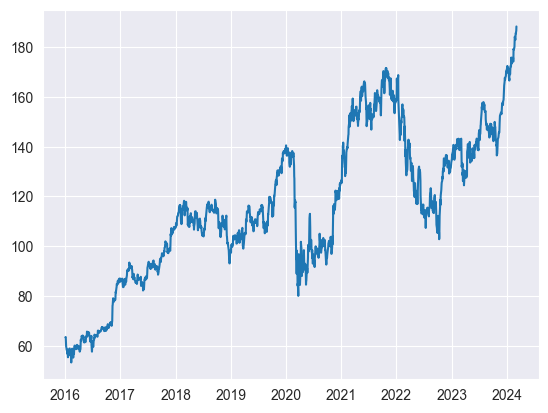

In [31]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['vwap'])

In [32]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str) + timedelta(n)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['vwap'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2024-03-05'
windowed_df = df_to_windowed_df(df,
                                str(df.index[0]).split(' ')[0],
                                str(df.index[-1]).split(' ')[0],
                                n=3)
windowed_df.tail()

,Target Date,Target-3,Target-2,Target-1,Target
2048,2024-02-28,184.196089,183.327353,182.947579,184.413387
2049,2024-02-29,183.327353,182.947579,184.413387,185.571020
2050,2024-03-01,182.947579,184.413387,185.571020,185.490087
2051,2024-03-04,184.413387,185.571020,185.490087,186.647544
2052,2024-03-05,185.571020,185.490087,186.647544,188.315997


In [33]:
str(df.index[-1]).split(' ')[0]

'2024-03-05'

In [34]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((2053,), (2053, 3, 1), (2053,))

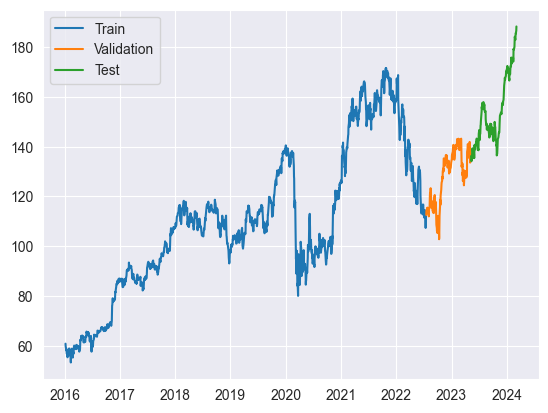

In [35]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [36]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras import layers
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1),
                    layers.Activation('linear')
                    ])

model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0000e+00 - loss: 109.3602 - val_accuracy: 0.0000e+00 - val_loss: 122.2178
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 92.8592 - val_accuracy: 0.0000e+00 - val_loss: 55.7712
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 26.7307 - val_accuracy: 0.0000e+00 - val_loss: 19.3015
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 17.3052 - val_accuracy: 0.0000e+00 - val_loss: 1.9210
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 2.5384 - val_accuracy: 0.0000e+00 - val_loss: 1.9058
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 1.6148 - val_accuracy: 0.0000e+00 - val_loss: 1.5923
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 1.5094 - val_accuracy: 0.0000e+00 - val_loss: 2.9266
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


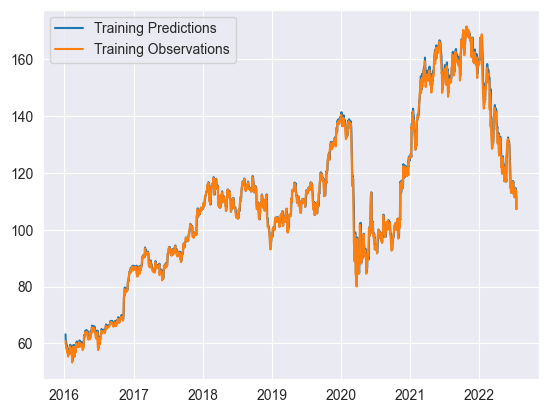

In [37]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step


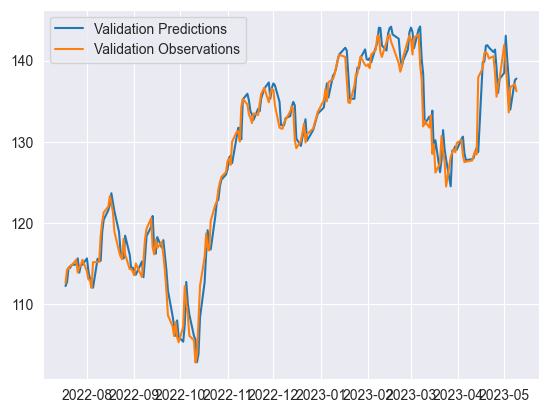

In [38]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step


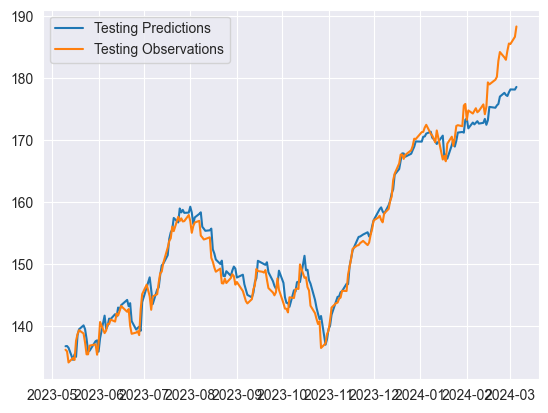

In [39]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

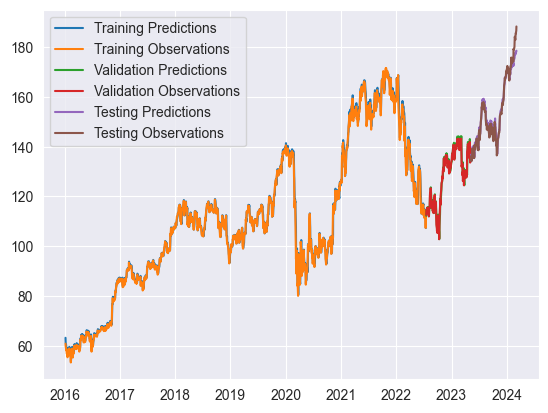

In [40]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [41]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

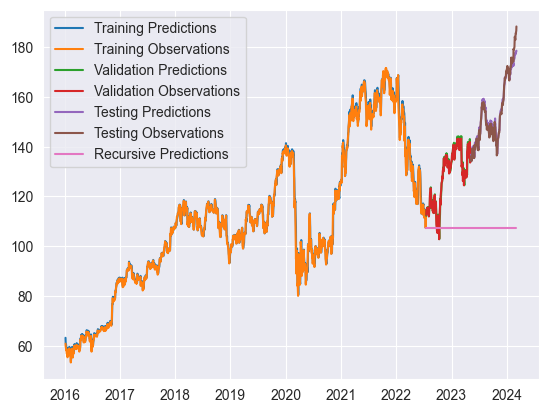

In [42]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])